# VAE

> In this module, we train a variational autoencoder

Adapted from:
- [https://www.youtube.com/watch?v=8AgZ9jcQ9v8&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=17](https://www.youtube.com/watch?v=8AgZ9jcQ9v8&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=17)

In [1]:
#| default_exp vae

In [2]:
# |export
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import nn
from torch.nn import init
from torch.optim import lr_scheduler
from torchmetrics import Metric

from slowai.attention import ConditionalTAUnet, conditional_train
from slowai.cos_revisited import aesthetics
from slowai.ddpm import get_dls as get_fashion_dls
from slowai.learner import (
    Callback,
    DeviceCB,
    Learner,
    MetricsCB,
    ProgressCB,
    TrainCB,
    def_device,
    fashion_mnist,
    only,
    to_cpu,
)
from slowai.sgd import BatchSchedulerCB
from slowai.super_rez import KaimingMixin
from slowai.tinyimagenet_a import denorm, get_imagenet_dls
from slowai.utils import show_images

In [3]:
# |hide
aesthetics()

In [4]:
# |export
class Perceptron(nn.Sequential):
    def __init__(self, c_in, c_out, bias=True, act=nn.SiLU):
        layers = [nn.Linear(c_in, c_out, bias=bias)]
        if act:
            layers.append(act())
        layers.append(nn.BatchNorm1d(c_out))
        super().__init__(*layers)

In [5]:
# |export
class KaimingMixin:
    """Helper to initialize the network using Kaiming"""

    @staticmethod
    def init_kaiming(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight, a=0.2)
            if m.bias is not None:
                torch.nn.init.constant_(m.bias, 0)

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(cls.init_kaiming)
        return model

In [6]:
# |export
class VAE(nn.Module, KaimingMixin):
    """Variational autoencoder"""

    def __init__(self, c_in, c_hidden, c_bottleneck, layers=1):
        super().__init__()
        self.c_in = c_in
        self.c_hidden = c_hidden
        self.c_bottleneck = c_bottleneck

        middle_encoder = [Perceptron(c_hidden, c_hidden) for _ in range(layers)]
        self.encoder = nn.Sequential(Perceptron(c_in, c_hidden), *middle_encoder)
        self.mu = Perceptron(c_hidden, c_bottleneck, act=None)
        self.log_sigma = Perceptron(c_hidden, c_bottleneck, act=None)

        middle_decoder = [Perceptron(c_hidden, c_hidden) for _ in range(layers)]
        self.decoder = nn.Sequential(
            Perceptron(c_bottleneck, c_hidden),
            *middle_decoder,
            Perceptron(c_hidden, c_in, act=None)
        )

    def forward(self, x, _y=None):
        bs, *_ = x.shape
        x = self.encoder(x)
        μ = self.mu(x)
        log_σ = self.log_sigma(x)

        ε = torch.randn(bs, self.c_bottleneck, device=x.device)
        # Reconstruct the image by taking some noise, modulated by a learned variance,
        # and adding it to a learned mean
        z = μ + (0.5 * log_σ).exp() * ε
        # We return the reconstructed result, but except for training we are only
        # interested in the hidden activations
        return self.decoder(z), μ, log_σ

Sigma can go to 0 to preserve data in the activations, so we need a new loss function to make sure that the hidden distribution is normal. This is known as "Kullback–Leibler divergence" or "KLD" loss. This reaches a minimum when μ is 0 and σ is 1.

In [7]:
# |export
def kld_loss(μ, log_σ, eps=0, dim=None):
    return -0.5 * (1 + log_σ - μ.pow(2) - (log_σ + eps).exp()).mean(dim)

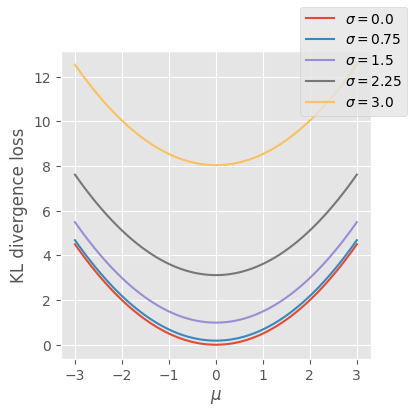

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.set(xlabel=r"$\mu$", ylabel="KL divergence loss")
for log_sigma_ in torch.linspace(0, 3, 5):
    mu = torch.linspace(-3, 3, 100).unsqueeze(0)
    log_sigma = torch.full((1, 1), log_sigma_)
    loss = kld_loss(mu, log_sigma, dim=0)
    ax.plot(mu.squeeze(), loss, label=r"$\sigma=${}".format(log_sigma_.item()))
fig.legend();

This is added to a normal reconstruction loss.

In [9]:
# |export
def vae_loss(inputs, x_pred, μ, log_σ):
    (x, _) = inputs
    kld_loss_ = kld_loss(μ, log_σ)
    bce_loss_ = F.binary_cross_entropy_with_logits(x_pred, x)
    loss = kld_loss_ + bce_loss_
    return loss

We want to be able to keep track of the KLD loss over time, so let's track it in a metric.

In [10]:
# |export
class MeanlikeMetric(Metric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.add_state("total", default=torch.tensor(0.0), dist_reduce_fx="sum")
        self.add_state("n", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, *args, **kwargs):
        self.total += self.delta(*args, **kwargs)
        self.n += 1

    def delta(self):
        raise NotImplementedError

    def compute(self):
        return self.total / self.n

In [11]:
# |export
class KLDMetric(MeanlikeMetric):
    def delta(self, μ, log_σ):
        return kld_loss(μ, log_σ).to(self.device)

In [12]:
# |export
class BCEMetric(MeanlikeMetric):
    def delta(self, x, x_pred):
        return F.binary_cross_entropy_with_logits(x_pred, x).to(self.device)

In [13]:
# |export
class MetricsCBWithKLDAndBCE(MetricsCB):
    def __init__(self, *ms, **metrics):
        super().__init__(*ms, **metrics)
        self.all_metrics["kld"] = self.kld = KLDMetric()
        self.all_metrics["bce"] = self.bce = BCEMetric()

    def after_batch(self, learn):
        super().after_batch(learn)
        x, _ = learn.batch
        x_pred, μ, log_σ = learn.preds
        self.kld.update(μ, log_σ)
        self.bce.update(x, x_pred)

In [14]:
# |export
class VAETrainCB(TrainCB):
    def get_loss(self, learn):
        x_pred, μ, log_σ = learn.preds
        learn.loss = learn.loss_func(learn.batch, x_pred, μ, log_σ)

    def backward(self, learn):
        learn.loss.backward()
        torch.nn.utils.clip_grad_norm_(learn.model.parameters(), max_norm=1.0)

In [15]:
# |export
def train(model, dls, lr=4e-3, n_epochs=4, extra_cbs=[], loss_fn=vae_loss):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        MetricsCBWithKLDAndBCE(),
        DeviceCB(),
        VAETrainCB(),
        *extra_cbs,
    ]
    learner = Learner(
        model,
        dls,
        loss_fn,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)
    return model

Set up the training run

In [16]:
dls = fashion_mnist(normalize=False, bs=256)

In [17]:
x, _ = dls.peek()
x.shape

torch.Size([256, 1, 28, 28])

In [18]:
x.min(), x.max()

(tensor(0.), tensor(1.))

In [19]:
# |export
class FashionMNISTForReconstruction(Callback):
    def before_batch(self, learn):
        x, y = learn.batch
        x = rearrange(x, "b c h w -> b (c h w)")
        learn.batch = (x, y)

loss,kld,bce,epoch,train
0.984,0.427,0.557,0,train
0.723,0.234,0.489,0,eval
0.546,0.097,0.448,1,train
0.453,0.046,0.408,1,eval
0.419,0.034,0.385,2,train
0.401,0.035,0.365,2,eval
0.393,0.034,0.359,3,train
0.390,0.039,0.350,3,eval
0.381,0.033,0.348,4,train
0.377,0.032,0.345,4,eval


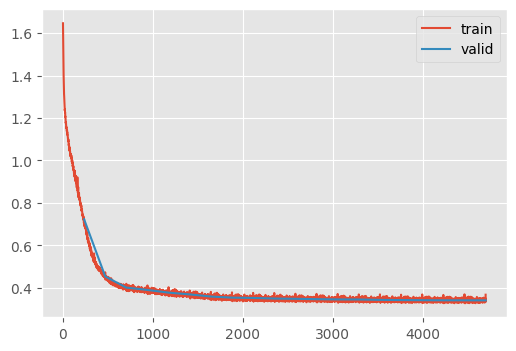

In [20]:
vae = train(
    VAE.kaiming((28**2), 400, 200, layers=2),
    dls,
    extra_cbs=[
        FashionMNISTForReconstruction(),
    ],
    n_epochs=20,
    lr=3e-2,
)

It took quite a bit of work to ensure that these results matched Howards':

- Use SiLU instead of ReLU
- Initialize leakily
- Normalize the output before visualizing
- Ensure there were the number of encoder layers as decoder layers
- Use the original FashionMNIST, not the one upsampled to 32x32 for DDPM.

In [21]:
with torch.no_grad():
    xb = rearrange(x, "b c h w -> b (c h w)")
    xb_pred, _, _ = to_cpu(vae(xb.cuda()))
xb_pred = rearrange(xb_pred.sigmoid(), "b (c h w) -> b c h w", c=1, h=28, w=28)
xb_pred = xb_pred.float()

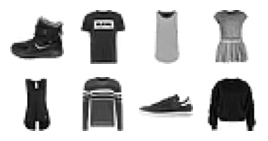

In [22]:
show_images(x[:8], imsize=0.8);

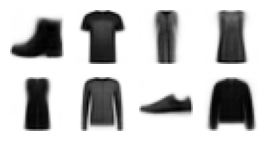

In [23]:
show_images(xb_pred[:8], imsize=0.8);

In [24]:
#| hide
import nbdev

nbdev.nbdev_export()